In [101]:
# Set up and load data
# Includes
import sys
import os
import numpy as np
import json
import os


# Setup paths containing utility
curr_folder = os.getcwd()
sys.path.insert(0, os.path.join(curr_folder,'../../../app'))

# Utils imports for loading data
from utils import save_data, load_data, exists_datafolder
from utils import load_SQuAD_train, load_SQuAD_dev
from utils import get_foldername
from utils_NLP import text2sentences,words2words_blanked,words2words_hashblank,words2answers
from utils_NLP import words2text
from utils_SQuAD import OR_arts_paragraph_fields,merge_arts_paragraph_fields

# Plotting includes
from utils_EDAplots import plotbar_train_dev,plothist_train_dev,plotbar_train_dev2,plothist_train_dev2

# Stats saving stuff
from utils_EDA import calcstats_train_dev

# Import fig stuff
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [102]:
# Option for merging NER data into combined model
merge_in_NER_data = False

# Load and merge ground truth and MODEL data

In [103]:
!pwd

/home/davestanley/Dropbox/git/mindpocket/train_model/articles_batch5.0/model8e0c37


In [104]:
# Load data containing MODEL (predictions)
foldername = os.path.join('SQ_pp_b4m0c2')
arts_train = load_data('train.json',foldername,prepend_data_folder=False)
arts_dev = load_data('dev.json',foldername,prepend_data_folder=False)

# All articles
Ntrain = len(arts_train)
Ndev = len(arts_dev)

arts = arts_train + arts_dev
print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])

Frédéric_Chopin


In [105]:
# Trim down newly loaded articles to match Narticles in training set
ind_train = slice(0,Ntrain)
ind_dev = slice(0,Ndev)

# Chosen display articles
ind_ex_train = 1                   # Example from training set - Chopin
ind_ex_dev = Ntrain + (467-442)    # Example from dev set - Immune system
ind_ex_dev = 105                   # Pitch

In [106]:
# Load blanks data (ground truth)
foldername = get_foldername('sq_pp_training')
arts3 = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
print(arts3[1]['title'])
# print(arts3[1]['paragraphs'][0]['context_blanked'])


Frédéric_Chopin


In [107]:
# Make sure all titles match
all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts3)]
titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts3)]
print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
if not sum(titles_match_bool) == len(titles_match_bool):
    raise ValueError('Articles mismatch.')


Matching titles: 477 
Total articles 477


In [108]:
# Merge ground truth blanks with original data to get full dataset
list_of_fields = ['context_blanked','blank_classification']
arts = merge_arts_paragraph_fields(arts,arts3,list_of_fields)

# print(arts[1]['title'])
# print(arts[1]['paragraphs'][0]['context'])
# print(arts[1]['paragraphs'][0]['context_blanked'])

In [109]:
arts[ind_ex_train]['paragraphs'][0]['context']

'Frédéric François Chopin (/ˈʃoʊpæn/; French pronunciation: \u200b[fʁe.de.ʁik fʁɑ̃.swa ʃɔ.pɛ̃]; 22 February or 1 March 1810 – 17 October 1849), born Fryderyk Franciszek Chopin,[n 1] was a Polish and French (by citizenship and birth of father) composer and a virtuoso pianist of the Romantic era, who wrote primarily for the solo piano. He gained and has maintained renown worldwide as one of the leading musicians of his era, whose "poetic genius was based on a professional technique that was without equal in his generation." Chopin was born in what was then the Duchy of Warsaw, and grew up in Warsaw, which after 1815 became part of Congress Poland. A child prodigy, he completed his musical education and composed his earlier works in Warsaw before leaving Poland at the age of 20, less than a month before the outbreak of the November 1830 Uprising.'

In [110]:
# Convert AllenNLP Model blanks classification into standard format

# If doing merge, use unique name for this model result. Otherwise, use generic name
if merge_in_NER_data: fieldname = 'blank_classified_allenMODEL'
else: fieldname = 'blank_classified_allen'


from utils_NLP import allenNLP_classify_blanks
arts = allenNLP_classify_blanks(arts,'0',fieldname)
arts[0]['paragraphs'][0].keys()

dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])

# Load NER data and merge into arts dataset

In [111]:

if merge_in_NER_data:
    # Load data containing NEP (predictions)
    foldername = get_foldername('sq_pp_ner')

    arts_NER = load_data('train.json',foldername)[ind_train] + load_data('dev.json',foldername)[ind_dev]
    print(arts[1]['title'])
    # print(arts[1]['paragraphs'][0]['context'])

    # Make sure all titles match
    all_title_pairs = [(a1['title'],a3['title']) for a1,a3 in zip(arts,arts_NER)]
    titles_match_bool = [a1['title'] == a3['title'] for a1,a3 in zip(arts,arts_NER)]
    print("Matching titles: {} \nTotal articles {}".format(sum(titles_match_bool),len(titles_match_bool)))
    if not sum(titles_match_bool) == len(titles_match_bool):
        raise ValueError('Articles mismatch.')

    # Convert AllenNLP Model blanks classification into standard format
    from utils_NLP import allenNLP_classify_blanks
    arts_NER = allenNLP_classify_blanks(arts_NER,'O','blank_classified_allenNER')
    print(arts_NER[0]['paragraphs'][0].keys())

    # Merge NER data into full dataset
    list_of_fields = ['blank_classified_allenNER']
    arts = merge_arts_paragraph_fields(arts,arts_NER,list_of_fields)
    print(arts[0]['paragraphs'][0].keys())

In [112]:
# OR operation on blank_classified_allenMODEL and blank_classified_allenNER into blank_classified_allenMODEL

if merge_in_NER_data:
    destination_fieldname = 'blank_classified_allen'
    arts = OR_arts_paragraph_fields(arts,['blank_classified_allenMODEL','blank_classified_allenNER'],destination_fieldname)

    p = arts[0]['paragraphs'][1]
    print(p['blank_classified_allenNER'])
    print(p['blank_classified_allenMODEL'])
    print(p['blank_classified_allen'])


# Compare paragraph word reconstructions

This just looks at the words in the different saved fiels files to make sure all the words match up 1:1 (otherwise, this could mess up our evaluations). Not looking at blanks here at all. The next sectoin looks at the blanks

In [113]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

## AllenNLP Words

In [114]:
words = p['allenNER']['words'].split()
tags = p['allenNER']['tags'].split()
print(len(words))
print(len(tags))
print(words2text(words))
print(len(words2text(words)))

95
95
Pitch is an auditory sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the frequency of vibration. Pitch is closely related to frequency, but the two are not equivalent. Frequency is an objective, scientific attribute that can be measured. Pitch is each person 's subjective perception of a sound, which can not be directly measured. However, this does not necessarily mean that most people wo n't agree on which notes are higher and lower.
522


## Context

In [115]:
from utils_NLP import allenNLP_split_words, join_punctuation

context = p['context']
context_split = allenNLP_split_words(context)

# context_reassembled = ' '.join(context_split)
context_reassembled = words2text(context_split)

print(len(context_split))
# print(words2text(context_split))
# print(len(words2text(context_split)))
print(context_reassembled)
print(len(context_reassembled))


95
Pitch is an auditory sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the frequency of vibration. Pitch is closely related to frequency, but the two are not equivalent. Frequency is an objective, scientific attribute that can be measured. Pitch is each person 's subjective perception of a sound, which can not be directly measured. However, this does not necessarily mean that most people wo n't agree on which notes are higher and lower.
522


## Context_blanked

In [116]:
print(len(p['blank_classification']))
print(p.keys())
print(p['context_blanked'])

95
dict_keys(['qas', 'context', 'allenNER', 'context_blanked', 'blank_classification', 'blank_classified_allen'])
______ is an ______ sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the ______ of vibration . ______ is closely related to ______ , but the two are not equivalent . ______ is an objective , scientific attribute that can be measured . ______ is each person 's subjective perception of a sound , which can not be directly measured . However , this does not necessarily mean that most people wo n't agree on which notes are higher and lower .


In [117]:
# Answers
for i,c in enumerate(p['blank_classification']):
    if c == 1: print(context_split[i])

Pitch
auditory
frequency
Pitch
frequency
Frequency
Pitch


# Single paragraph - Compare blanks

## First, just look at the raw text

In [118]:
# Pull out sample paragraph
p = arts[ind_ex_dev]['paragraphs'][0]

# # Print all AllenNLP classifications
# print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [119]:


print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 95. Length ground truth blanks: 95


In [120]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


============			==========
Ground truth			Prediction
============			==========
______				Pitch
is				is
an				an
______				auditory
sensation				sensation
in				in
which				which
a				a
listener				listener
assigns				assigns
musical				musical
tones				tones
to				to
relative				relative
positions				positions
on				on
a				a
musical				musical
scale				scale
based				based


## Ground truth blanked

In [121]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

______ is an ______ sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the ______ of vibration. ______ is closely related to ______, but the two are not equivalent. ______ is an objective, scientific attribute that can be measured. ______ is each person 's subjective perception of a sound, which can not be directly measured. However, this does not necessarily mean that most people wo n't agree on which notes are higher and lower.
Answers:
['Pitch', 'auditory', 'frequency', 'Pitch', 'frequency', 'Frequency', 'Pitch']


In [122]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

Pitch is an auditory sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the frequency of vibration. Pitch is closely related to frequency, but the two are not equivalent. Frequency is an objective, scientific attribute that can be measured. Pitch is each person 's subjective perception of a sound, which can not be directly measured. However, this does not necessarily mean that most people wo n't agree on which notes are higher and lower.
Answers:
[]


In [131]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [132]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

0.9507422402159245
0.9507422402159245
4
18


In [133]:
# # Sensitivity, hit rate, recall, or true positive rate
# TPR = TP/(TP+FN)
# # Specificity or true negative rate
# TNR = TN/(TN+FP) 
# # Precision or positive predictive value
# PPV = TP/(TP+FP)
# # Negative predictive value
# NPV = TN/(TN+FN)
# # Fall out or false positive rate
# FPR = FP/(FP+TN)
# # False negative rate
# FNR = FN/(TP+FN)
# # False discovery rate
# FDR = FP/(TP+FP)


In [134]:
# print(TPR)
# print(FPR)

In [135]:
Nsentences = len(text2sentences(p['context']))
print("Nsentences={}".format(str(Nsentences)))

Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))



Nsentences=5
Nsentences_from_words=53


In [136]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.07547169811320754
0.33962264150943394


# Single article - compare blanks

In [137]:
##### Pull out sample paragraph
a = arts[ind_ex_dev]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

Pitch_(music)


In [138]:

print("Length Allen tags: {}. Length ground truth blanks: {}".format(len(tags),len(blank_classification)))

Length Allen tags: 1482. Length ground truth blanks: 1482


In [139]:
# Side by side compare
words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=30
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
print("Original" + '\t\t\t' + "Ground truth" + '\t\t\t' + "Prediction")
print("========" + '\t\t\t' + "============" + '\t\t\t' + "==========")
for o,c,w in zip(words[:N],words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(o + '\t\t\t\t' + c + '\t\t\t\t' + w)


========			============			==========
Original			Ground truth			Prediction
========			============			==========
Pitch				______				Pitch
is				is				is
an				an				an
auditory				______				auditory
sensation				sensation				sensation
in				in				in
which				which				which
a				a				a
listener				listener				listener
assigns				assigns				assigns
musical				musical				musical
tones				tones				tones
to				to				to
relative				relative				relative
positions				positions				positions
on				on				on
a				a				a
musical				musical				musical
scale				scale				scale
based				based				based
primarily				primarily				primarily
on				on				on
their				their				their
perception				perception				perception
of				of				of
the				the				the
frequency				______				frequency
of				of				of
vibration				vibration				vibration
.				.				.


In [140]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [141]:
print(ACC)
print(ACC2)

0.9507422402159245
0.9507422402159245


In [142]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [143]:
print(TPR)
print(FPR)

0.06779661016949153
0.012649332396345749


In [144]:
Nsentences2 = len(text2sentences(words2text(words)))
print("Nsentences_from_words={}".format(str(Nsentences2)))

Nsentences_from_words=53


In [145]:
TPpersent = TP / Nsentences2
FPpersent = FP / Nsentences2

print(TPpersent)
print(FPpersent)

0.07547169811320754
0.33962264150943394


## Ground truth blanked vs predicted blanked

In [146]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

Answers:
{'generated', 'missing', 'pitch', 'ambiguous', 'auditory', 'Frequency', 'partials', '1', 'unnecessary', 'fundamental', 'overtones', '1,400', '60.5', '69', 'numerous', '12', 'spelling', 'frequency', 'snare', 'sound', 'ambiguities', '100', 'indefinite', 'drum', 'numerical', 'rapid', 'logarithmic', 'octave', 'two', 'slower', 'Pitch', 'A4'}


In [147]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

Answers:
{'C♯', 'partials', 'Sebastian', 'A880', 'snare', 'Johann', '1.05946', '440', '1200', '1,400', '60.5', '880', '0.6', 'cochlear', 'vibrate', 'A440', 'cochlea'}


## Fract of answers blanked

### Fract answers blanked vs num answers

In [148]:

# Pseudocode
# For each answer, loop through the words and count the number of times it occurs.
# Get the set of blanks booleans associated with each occurrence of that words, and calculate the
# mean. Will do this for each word in the article, and then each article in the corpus. For each
# article, rank the words by their proximity to 50 % 

myanswers_unique = list(set(words2answers(words,tags)))

fracblanked = []
numblanked = []
for ans in myanswers_unique:
    indices = [i for i, w in enumerate(words) if w == ans]
    tags_curr = [tags[i] for i in indices]
    #words_curr = [words[i] for i in indices]
    fracblanked.append(sum(tags_curr)/len(tags_curr)*100)
    numblanked.append(len(tags_curr))

Text(0, 0.5, 'Num occurrences')

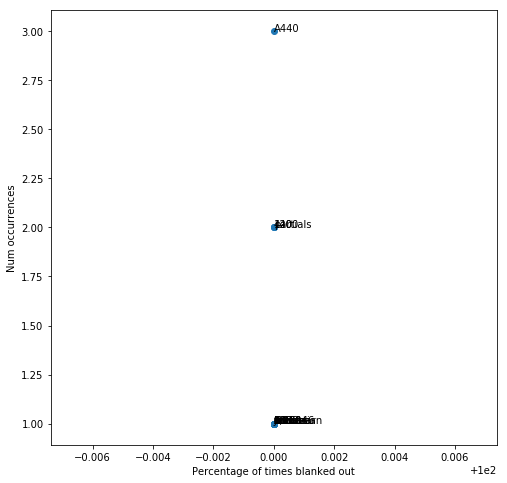

In [149]:
# Do scatter plot
y = numblanked
z = fracblanked
n = myanswers_unique

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))
plt.xlabel('Percentage of times blanked out')
plt.ylabel('Num occurrences')

### Fract answers blanked for all answers

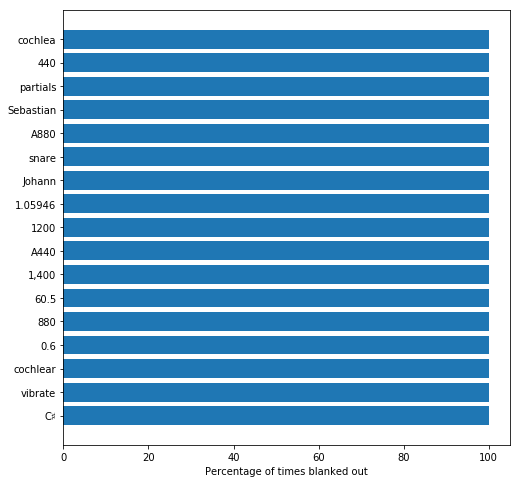

In [150]:
import numpy as np
import pandas as pd

d = {'myanswers_unique':myanswers_unique,'fracblanked':fracblanked}

df = pd.DataFrame(data=d);

df2 = df.sort_values(by='fracblanked',ascending=True);



N=30          # of data points to show
figure(num=None, figsize=(8, 8),facecolor='w', edgecolor='k')
bars = (df2['myanswers_unique'].values.tolist())[0:N]
y_pos = np.arange(len(bars))
val = (df2['fracblanked'].values.tolist())[0:N]
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('Percentage of times blanked out')
# Show graphic
plt.show()



### Fractions of POS/NER tags blanked

In [151]:
import spacy

nlp = spacy.load('en_core_web_sm')
doc = nlp(words2text(words))

pos=[]
ner=[]
dep=[]
for token in doc:
    pos.append(token.pos_)
    ner.append(token.ent_type_)
    dep.append(token.dep_)

# Build a dataframe to store everything
d = {'ind': range(len(words)),
     'words' : words,
    'tags':tags,
    'pos':pos,
    'ner':ner,
    'dep':dep}

df = pd.DataFrame(data=d)

xlabs=[]
yvals=[]

# Search through keys and unique items therein, counting "Trues"
keys = ['ner']
for k in keys:
    for item in list(set(d[k])):
        df2 = df.loc[df[k] == item]
        mysum = df2.sum()['tags']
        N = len(df2)
        
        xlabs.append(k.upper() + ': ' + item.lower())
        yvals.append(mysum/N*100)

        


In [152]:
df3 = df.loc[df['ner'] == 'PERSON']
df3           # Hmmm

,ind,words,tags,pos,ner,dep
293,293,Johann,1,PROPN,PERSON,compound
294,294,Sebastian,1,PROPN,PERSON,compound
295,295,Bach,0,PROPN,PERSON,pobj


In [153]:
df = pd.DataFrame(data={'xlabs':xlabs,'yvals':yvals})
df = df.sort_values(by='yvals',ascending=True)
df

,xlabs,yvals
2,NER: norp,0.000000
6,NER: gpe,0.000000
8,NER: ordinal,0.000000
9,NER: money,0.000000
10,NER: language,0.000000
11,NER: org,0.000000
0,NER:,0.570207
4,NER: cardinal,16.279070
7,NER: percent,33.333333
3,NER: person,66.666667


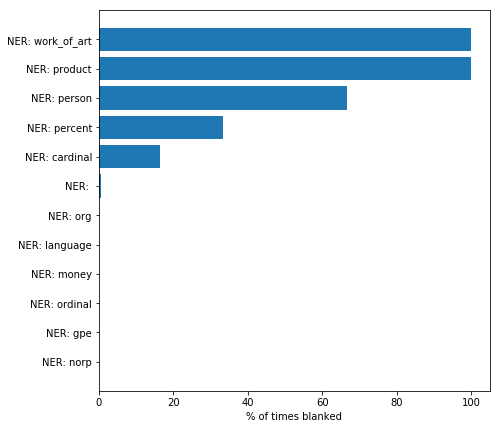

In [154]:
figure(num=None, figsize=(7,7),facecolor='w', edgecolor='k')
bars = df['xlabs']
y_pos = np.arange(len(bars))
val = df['yvals']

# Make fake dataset
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, val)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)

plt.xlabel('% of times blanked')
# Show graphic
plt.show()


## Whole article

### Ground truth

In [155]:

# print('--------------- GROUND TRUTH ---------------')

# # Pull out sample paragraph
# for p in arts[ind_ex_dev]['paragraphs']:
#     # # Print all AllenNLP classifications
#     # print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

#     # AllenNLP results
#     words = p['allenNER']['words'].split()
#     # tags = p['allenNER']['tags'].split()
#     # tags = [not t == '0' for t in tags]   # Convert to binary
#     tags = p['blank_classified_allen']

#     # Ground truth
#     blank_classification = p['blank_classification']

#     words_blanked_ground_truth = words2words_blanked(words,blank_classification)
#     words_blanked_allen = words2words_blanked(words,tags)
#     words_hash_ground_truth = words2words_hashblank(words,blank_classification)
#     words_hash_allen = words2words_hashblank(words,tags)
    
    
#     # Blanked text
#     print(words2text(words_hash_ground_truth))

#     # Answers    
#     myanswers = words2answers(words,blank_classification)
#     print("Answers:")
#     print(myanswers)

    

### My model

In [156]:

print('--------------- MY MODEL ---------------')
# Pull out sample paragraph
for p in arts[ind_ex_dev]['paragraphs']:
    # # Print all AllenNLP classifications
    # print([(a,b) for a,b in zip(p['allenNER']['words'].split(), p['allenNER']['tags'].split())])

    # AllenNLP results
    words = p['allenNER']['words'].split()
    # tags = p['allenNER']['tags'].split()
    # tags = [not t == '0' for t in tags]   # Convert to binary
    tags = p['blank_classified_allen']

    # Ground truth
    blank_classification = p['blank_classification']

    words_blanked_ground_truth = words2words_blanked(words,blank_classification)
    words_blanked_allen = words2words_blanked(words,tags)
    words_hash_ground_truth = words2words_hashblank(words,blank_classification)
    words_hash_allen = words2words_hashblank(words,tags)
    
    # Blanked text
    print(words2text(words_hash_allen))

    # Answers    
    myanswers = list(set(words2answers(words,tags)))
    print("Answers:")
    print(myanswers)
    

    

--------------- MY MODEL ---------------
Pitch is an auditory sensation in which a listener assigns musical tones to relative positions on a musical scale based primarily on their perception of the frequency of vibration. Pitch is closely related to frequency, but the two are not equivalent. Frequency is an objective, scientific attribute that can be measured. Pitch is each person 's subjective perception of a sound, which can not be directly measured. However, this does not necessarily mean that most people wo n't agree on which notes are higher and lower.
Answers:
[]
This creates a linear pitch space in which octaves have size 12, semitones ( the distance between adjacent keys on the piano keyboard ) have size 1, and ___A440___ is assigned the number 69. ( See Frequencies of notes. ) Distance in this space corresponds to musical intervals as understood by musicians. An equal - tempered semitone is subdivided into 100 cents. The system is flexible enough to include " microtones " not 

# All articles - compare blanks

In [ ]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []            # Article-level bads
sbc0 = []
st0 = []
Nwords0 = []

art = arts[:]

i=-1
for a in art:
    i=i+1
    # AllenNLP results
    words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
#     tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
#     tags = [not t == '0' for t in tags]   # Convert to binary
    tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

    # Ground truth
    blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]
    blank_classification = [b == 1 for b in blank_classification] # Convert to binary

    Nsentences2 = len(text2sentences(words2text(words)))

    sbc = sum(blank_classification)
    st = sum(tags)
    if sbc == 0 or st == 0:
        print("Warning article {} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(sbc),str(st)))

        # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
        # This is ok because we'll skip them later if want to do stats - that's what abads is for
        TPR = 0.0
        FPR = 0.0
        ACC = 0.0
        TP = 100
        FP = 100
        FN = 100
        TN = 100

        TPpersent = 1
        FPpersent = 1
        abads.append(i)
    else:
        TP = sum([b and t for b,t in zip(blank_classification,tags)])
        FP = sum([not b and t for b,t in zip(blank_classification,tags)])
        FN = sum([b and not t for b,t in zip(blank_classification,tags)])
        TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
        ACC = (TP+TN)/(TP+FP+FN+TN)
        ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP)
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Per sententance values
        TPpersent = TP / Nsentences2
        FPpersent = FP / Nsentences2

    TPR0.append(TPR)
    FPR0.append(FPR)
    ACC0.append(ACC)
    TP0.append(TP)
    FP0.append(FP)
    FN0.append(FN)
    TN0.append(TN)
    TPpersent0.append(TPpersent)
    FPpersent0.append(FPpersent)
    sbc0.append(sbc)
    st0.append(st)
    Nwords0.append(len(tags))

In [ ]:
# Print tiles of bad articles
for ab in abads:
    print(art[ab]['title'])

In [ ]:
# Calculate how this affects Ntrain / Ndev
Ntrain_bad = len([b for b in abads if b < Ntrain])
Ndev_bad = len([b for b in abads if b >= Ntrain])
print('Ntrain={}'.format(str(Ntrain)))
print('Ndev={}'.format(str(Ndev)))
print('Ntrain_bad={}'.format(str(Ntrain_bad)))
print('Ndev_bad={}'.format(str(Ndev_bad)))




## Plot TPR

In [ ]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot FPR

In [ ]:
myvar = FPR0
varname = 'FPR'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# REdefine for plotting with with more decimal places
def plothist_train_dev2(myvar,Ntrain,Ndev,xlabel='value',ylabel='N Articles',devbins=30):
    # Import fig stuff
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    import statistics

    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize=(15, 4));
    ax1.hist(myvar[0:Ntrain-1], bins=30);  # arguments are passed to np.histogram
    ax1.set_title("Narticles={}, median={}, mean={}".format(str(Ntrain),'{0:.4f}'.format(statistics.median(myvar[0:Ntrain-1])),'{0:.2f}'.format(statistics.mean(myvar[0:Ntrain-1]))));
    ax1.set_ylabel('N Articles');
    ax1.set_xlabel(xlabel);

    ax2.hist(myvar[Ntrain:], bins=devbins);  # arguments are passed to np.histogram
    ax2.set_title("Narticles={}, median={}, mean={}".format(str(Ndev),'{0:.4f}'.format(statistics.median(myvar[Ntrain:])),'{0:.2f}'.format(statistics.mean(myvar[Ntrain:]))));
    ax2.set_xlabel(xlabel);
    return {'ax1': ax1, 'ax2':ax2}


# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
ax = plothist_train_dev2(myvar,Ntrain,Ndev,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot ACC

In [ ]:
myvar = ACC0
varname = 'Accuracy'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{} per article'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
set(ax['ax1'].set_xlim(0,1));
set(ax['ax2'].set_xlim(0,1));



## Plot True positives per sentence

In [ ]:
myvar = TPpersent0
varname = 'True positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Plot False positives per sentence

In [ ]:
myvar = FPpersent0
varname = 'False positives per sentence'

# Plot bargraph
plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrain-Ntrain_bad,Ndev-Ndev_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find articles containing a lot of true positives

In [ ]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.08]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.08 and x < 1.0 and i > Ntrain and i not in abads]

print(len(inds))
chosen_ind = inds[0]
print('Article #{}'.format(str(i)))
print(arts[chosen_ind]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

In [ ]:
# Pull out sample paragraph
a = arts[chosen_ind]
print(a['title'])

# AllenNLP results
words = [w for p in a['paragraphs'] for w in p['allenNER']['words'].split()]
# tags = [t for p in a['paragraphs'] for t in p['allenNER']['tags'].split()]
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = [t for p in a['paragraphs'] for t in p['blank_classified_allen']]

# Ground truth
blank_classification = [bc for p in a['paragraphs'] for bc in p['blank_classification']]

In [ ]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


## Ground truth blanked

In [ ]:
# Blanked text
# print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(set(myanswers))

In [ ]:
# Blanked text
# print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(set(myanswers))

# All paragraphs - compare blanks

In [ ]:
# Initialize stuff
TPR0 = []
FPR0 = []
ACC0 = []
Nsentences0 = []
TP0 = []
FP0 = []
FN0 = []
TN0 = []
TPpersent0 = []
FPpersent0 = []
abads = []
indices = {'i':[],'j':[],'k':[]}

art = arts[:]


# Only track true positives and false positive to avoid having to deal with other annoying edge cases
i=-1
k=-1
Ntrainp = 0
Ndevp=0
for a in art:
    i=i+1
    j=-1
    for p in a['paragraphs']:
        j=j+1
        k=k+1
        if i < Ntrain: Ntrainp=Ntrainp+1;
        else: Ndevp = Ndevp+1
        # AllenNLP results
        words = [w for w in p['allenNER']['words'].split()]
        tags = [t for t in p['allenNER']['tags'].split()]
        tags = [not t == '0' for t in tags]   # Convert to binary

        # Ground truth
        blank_classification = [bc for bc in p['blank_classification']]
        blank_classification = [b == 1 for b in blank_classification] # Convert to binary

        Nsentences2 = len(text2sentences(words2text(words)))

        sbc = sum(blank_classification)
        st = sum(tags)
        if sbc == 0:
            #print("Warning article {}, paragraph P{} contains {} ground truth blanks and {} tags. Likely bad".format(str(i),str(j),str(sbc),str(st)))

            # Make up some dummy values so don't confuse for a REAL outlier in plots. Should just drop this data in the future
            # This is ok because we'll skip them later if want to do stats - that's what bads is for
            TPR = 0.7
            FNR = 0.7
            ACC = 0.7
            TP = 100
            FP = 100
            FN = 100
            TN = 100
            TPpersent = 1
            FPpersent = 1
            abads.append(k)       # kth paragraph is bad
        else:
            TP = sum([b and t for b,t in zip(blank_classification,tags)])
            FP = sum([not b and t for b,t in zip(blank_classification,tags)])
            FN = sum([b and not t for b,t in zip(blank_classification,tags)])
            TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
#             ACC = (TP+TN)/(TP+FP+FN+TN)
            ACC = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

            # Sensitivity, hit rate, recall, or true positive rate
            TPR = TP/(TP+FN)
#             # Specificity or true negative rate
#             TNR = TN/(TN+FP) 
#             # Precision or positive predictive value
#             PPV = TP/(TP+FP)
#             # Negative predictive value
#             NPV = TN/(TN+FN)
#             # Fall out or false positive rate
#             FPR = FP/(FP+TN)
            # False negative rate
            FNR = FN/(TP+FN)
#             # False discovery rate
#             FDR = FP/(TP+FP)

            # Per sententance values
            TPpersent = TP / Nsentences2
            FPpersent = FP / Nsentences2
    
        TPR0.append(TPR)
        FPR0.append(FPR)
        ACC0.append(ACC)
        TP0.append(TP)
        FP0.append(FP)
        FN0.append(FN)
        TN0.append(TN)
        TPpersent0.append(TPpersent)
        FPpersent0.append(FPpersent)
        indices['i'].append(i)
        indices['j'].append(j)
        indices['k'].append(k)



In [ ]:
FPR0[0:10]

In [ ]:
# # # Plot the histogram without containing any bads
# Calculate how this affects Ntrain / Ndev
Ntrainp_bad = len([b for b in abads if b < Ntrainp])
Ndevp_bad = len([b for b in abads if b >= Ntrainp])


In [ ]:
print(Ntrainp)
print(Ndevp)
print(Ntrainp_bad)
print(Ndevp_bad)
max(abads)
len(FN0)

x = []
for a in abads:
    x.append(TPR0[a])


## Plot TPR

In [ ]:
myvar = TPR0
varname = 'TPR'

# Plot bargraph (Don't plot figure for each paragraph!)
# plotbar_train_dev2(myvar,Ntrain,Ndev,ylabel='{}'.format(varname),xlabel='Article #')

# # # Plot the histogram without containing any bads
# myvar without the bad articles
myvar2 = [tp for i, tp in enumerate(myvar) if i not in abads]

# Plot the histogram
ax = plothist_train_dev2(myvar2,Ntrainp-Ntrainp_bad,Ndevp-Ndevp_bad,xlabel=varname,ylabel='N Articles',devbins='auto')
# set(ax['ax1'].set_xlim(0,1));
# set(ax['ax2'].set_xlim(0,1));



## Find paragraphs containing a lot of true positives

In [ ]:

# Inds of all articles >0.4 TPR
inds = [i for i,x in enumerate(TPR0) if x >=0.6]

# Inds of all articles >0.4 TPR and in dev dataset
inds = [i for i,x in enumerate(TPR0) if x >=0.4 and x < 1.0 and i > Ntrainp and i not in abads]

print(len(inds))
chosen_ind = inds[0]
i = indices['i'][chosen_ind]
j = indices['j'][chosen_ind]
k = indices['k'][chosen_ind]
print('Article #{} paragraph #{}'.format(str(i),str(j)))
print(arts[i]['title'])
print('True positive rate: {}'.format(str(TPR0[chosen_ind])))

In [ ]:
# Pull out sample paragraph
p = arts[i]['paragraphs'][j]

# AllenNLP results
words = p['allenNER']['words'].split()
# tags = p['allenNER']['tags'].split()
# tags = [not t == '0' for t in tags]   # Convert to binary
tags = p['blank_classified_allen']

# Ground truth
blank_classification = p['blank_classification']

In [ ]:
# Side by side compare

words_blanked_ground_truth = words2words_blanked(words,blank_classification)
words_blanked_allen = words2words_blanked(words,tags)

N=len(words_blanked_ground_truth)
N=20
print("============" + '\t\t\t' + "==========")
print("Ground truth" + '\t\t\t' + "Prediction")
print("============" + '\t\t\t' + "==========")
for c,w in zip(words_blanked_ground_truth[:N],words_blanked_allen[:N]):
    print(c + '\t\t\t\t' + w)


## Ground truth blanked

In [ ]:
# Blanked text
print(words2text(words_blanked_ground_truth))

# Answers    
myanswers = words2answers(words,blank_classification)
print("Answers:")
print(myanswers)

In [ ]:
# Blanked text
print(words2text(words_blanked_allen))

# Answers    
myanswers = words2answers(words,tags)
print("Answers:")
print(myanswers)

In [ ]:
TP = sum([b and t for b,t in zip(blank_classification,tags)])
FP = sum([not b and t for b,t in zip(blank_classification,tags)])
FN = sum([b and not t for b,t in zip(blank_classification,tags)])
TN = sum([not b and not t for b,t in zip(blank_classification,tags)])
ACC = (TP+TN)/(TP+FP+FN+TN)
ACC2 = sum([b == t for b,t in zip(blank_classification,tags)]) / len(tags)

In [ ]:
print(ACC)
print(ACC2)
print(TP)
print(FP)

In [ ]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)


In [ ]:
print(TPR)
print(FPR)